In [1]:
import os
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

from keras.layers import Flatten, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.losses import categorical_crossentropy

In [2]:
# Working with pre trained model 

base_model = MobileNet(input_shape=(224, 224, 3), include_top=False)

for layer in base_model.layers:
  layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(units=7 , activation='softmax')(x)

# creating our model.
model = Model(base_model.input, x)

ValueError: The last dimension of the inputs to a Dense layer should be defined. Found None. Full input shape received: (None, None)

In [3]:
model.compile(optimizer='adam', loss=categorical_crossentropy , metrics=['accuracy'])

In [4]:
sessions = {}
directory_template = './data/mmi/Sessions/$session$/'
for session in os.listdir('./data/mmi/Sessions'):
    # Find XML filename
    directory = directory_template.replace('$session$', session)
    files = os.listdir(directory)
    xml_filename = directory + files[1]
    
    # Load AUs
    aus = []
    root = ET.parse(xml_filename).getroot()
    for au in root.iter('ActionUnit'):
        aus.append(au.attrib['Number'])
    
    # Load JPG filename
    jpg_filename = directory + files[0]
    
    sessions[session] = {
        'aus': aus,
        'img': jpg_filename
    }
    
assert len(sessions) == 493
print(f'{len(sessions)} sessions loaded')

493 sessions loaded


In [60]:
df_sessions = pd.DataFrame.from_dict(sessions, orient='index')
df_sessions.index.rename('session', inplace=True)

df_sessions_null = df_sessions.loc[df_sessions['aus'].apply(lambda x: len(x)) == 0]
df_sessions = df_sessions.loc[df_sessions['aus'].apply(lambda x: len(x)) != 0]

print(f'df_sessions_null: {df_sessions_null.shape}')
print(f'df_sessions: {df_sessions.shape}')
print()
df_sessions.info()
print()
df_sessions.head()

df_sessions_null: (265, 2)
df_sessions: (228, 2)

<class 'pandas.core.frame.DataFrame'>
Index: 228 entries, 2401 to 2653
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   aus     228 non-null    object
 1   img     228 non-null    object
dtypes: object(2)
memory usage: 5.3+ KB



,aus,img
session,,
2401,"[45, 5]",./data/mmi/Sessions/2401/S001-001.jpg
2402,"[10, 25]",./data/mmi/Sessions/2402/S001-002.jpg
2403,"[10, 11, 25]",./data/mmi/Sessions/2403/S001-003.jpg
2404,"[10, 11, 17, 18, 25, 38]",./data/mmi/Sessions/2404/S001-004.jpg
2405,"[10, 11, 25, 38]",./data/mmi/Sessions/2405/S001-005.jpg


In [61]:
train_datagen = ImageDataGenerator(
     zoom_range = 0.2, 
     shear_range = 0.2, 
     horizontal_flip=True, 
     rescale = 1./255
)

train_data = train_datagen.flow_from_dataframe(
  dataframe = df_sessions,
  directory=".",
  x_col = "img",
  y_col = "aus",
  subset = "training",
  batch_size = 32,
  seed = 42,
  shuffle = True,
  class_mode = "categorical",
  target_size = (24,24))

Found 228 validated image filenames belonging to 52 classes.


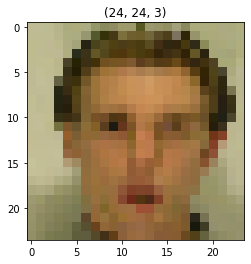

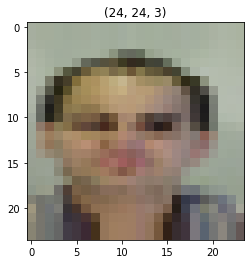

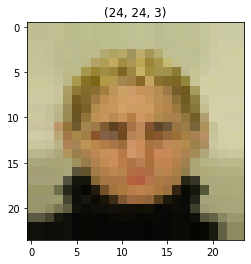

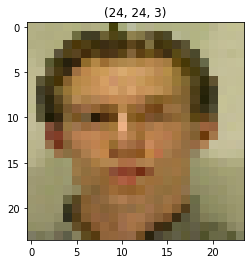

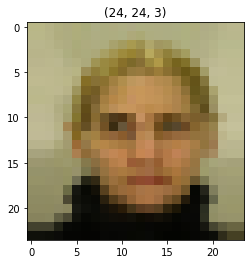

In [62]:
# to visualize the images in the traing data denerator 

t_img , label = train_data.next()

#-----------------------------------------------------------------------------
# function when called will prot the images 
def plotImages(img_arr, label):
  """
  input  :- images array 
  output :- plots the images 
  """
  count = 0
  for im, l in zip(img_arr,label) :
    plt.imshow(im)
    plt.title(im.shape)
    plt.axis = False
    plt.show()
    
    count += 1
    if count == 5:
      break

#-----------------------------------------------------------------------------
# function call to plot the images 
plotImages(t_img, label)

In [63]:
hist = model.fit_generator(
    train_data,
    steps_per_epoch=10,
    epochs=30,
    validation_data=train_data, 
    validation_steps=8
)

C:\Users\18.00050-9\AppData\Local\Temp\ipykernel_13884\3543267928.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\18.00050-9\AppData\Local\Temp\ipykernel_13884\2743396468.py", line 1, in <cell line: 1>
      hist = model.fit_generator(
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2260, in fit_generator
      return self.fit(
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 1787, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "C:\Users\18.00050-9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 5134, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[0,7] labels_size=[32,52]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_4101]

In [ ]:
# Loading the best fit model 
from keras.models import load_model
model = load_model("/content/best_model.h5")